In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Importing the SQuAD dataset

In [2]:
splits = {'train': 'train-00000-of-00001.parquet', 'validation': 'validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Kamitor/fwdhjlkfhqwiljfhqowiks/" + splits["train"])
df

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"
...,...,...,...,...,...
130314,5a7e070b70df9f001a875439,Matter,"The term ""matter"" is used throughout physics i...",Physics has broadly agreed on the definition o...,"{'text': [], 'answer_start': []}"
130315,5a7e070b70df9f001a87543a,Matter,"The term ""matter"" is used throughout physics i...",Who coined the term partonic matter?,"{'text': [], 'answer_start': []}"
130316,5a7e070b70df9f001a87543b,Matter,"The term ""matter"" is used throughout physics i...",What is another name for anti-matter?,"{'text': [], 'answer_start': []}"
130317,5a7e070b70df9f001a87543c,Matter,"The term ""matter"" is used throughout physics i...",Matter usually does not need to be used in con...,"{'text': [], 'answer_start': []}"


In [3]:
df.columns

Index(['id', 'title', 'context', 'question', 'answers'], dtype='object')

# Creating triples of context, question, and answer

In [4]:
examples = []
for _, row in df.iterrows():
    texts = row['answers']['text']
    if texts and texts[0].strip():      # keep only if the first answer is non‑empty
        context  = row['context']
        question = row['question']
        answer   = texts[0]
        examples.append((context, question, answer))

triples_df = pd.DataFrame(examples, columns=['context','question','answer'])
triples_df.shape

/tmp/ipykernel_31/320562734.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if texts and texts[0].strip():      # keep only if the first answer is non‑empty


(86821, 3)

# Check shortest contexts and compare variance

In [5]:
triples_df['context_len'] = triples_df['context'].str.split().apply(len)

triples_sorted = triples_df.sort_values('context_len')

subset_df = triples_sorted.head(20000).reset_index(drop=True)
print("Subset shape:", subset_df.shape)


Subset shape: (20000, 4)


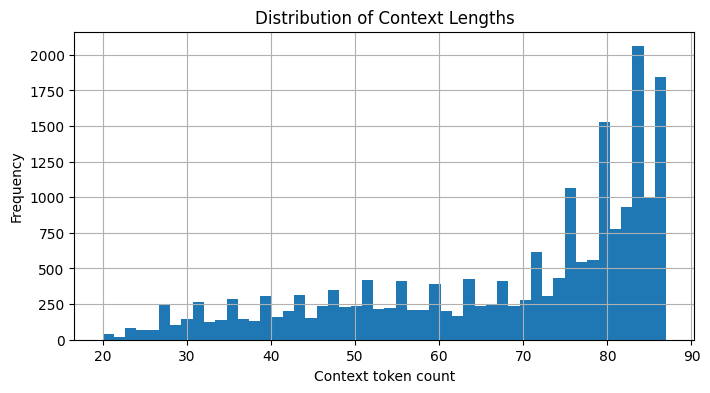

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
subset_df['context_len'].hist(bins=50)
plt.title('Distribution of Context Lengths')
plt.xlabel('Context token count')
plt.ylabel('Frequency')
plt.show()

The variance between word counts 30 to 70 seems little. Let's try taking this subset and checking out the new size

In [7]:
filtered_df = subset_df[(subset_df['context_len'] >= 30) & (subset_df['context_len'] <= 70)].reset_index(drop=True)

print(filtered_df.shape)
filtered_df.head()

(7697, 4)


,context,question,answer,context_len
0,"Later, during the Koine Greek period, the aspi...",The lenited Attic Greek yielded /θ ð/ in what ...,Medieval and Modern Greek,30
1,"On January 9, 1957, Karachay Autonomous Oblast...",What republic had the Karachay Autonomous Obla...,the Georgian SSR,30
2,"In January 2007, the average annual salary in ...",How far below England's South East region is S...,"£3,800",30
3,Sentient beings always suffer throughout saṃsā...,What is the first Nidāna?,ignorance,30
4,Sentient beings always suffer throughout saṃsā...,How are sentient beings freed from suffering?,by attaining Nirvana,30


# Split into 80/20


In [8]:
train_df = filtered_df.sample(frac=0.8, random_state=42).reset_index(drop=True)
val_df   = filtered_df.drop(train_df.index).reset_index(drop=True)
print("Train:", train_df.shape, "Validation:", val_df.shape)

Train: (6158, 4) Validation: (1539, 4)


# Phase 1: Input the question and output the answer


Capping the question and answer lengths at the 95th percentile of all lengths

In [9]:
# A) Combine question & context
for df in (train_df, val_df):
    df['qc'] = df['question'] + ' <sep> ' + df['context']

# B) Compute max_qc_len on TRAIN (95th percentile)
train_df['qc_len'] = train_df['qc'].str.split().apply(len)
train_df['answer_len'] = train_df['answer'].str.split().apply(len)
max_qc_len = int(np.percentile(train_df['qc_len'], 95))
max_a_len = int(np.percentile(train_df['answer_len'], 95))

Add start/end tokens to answers

In [10]:
for df in (train_df, val_df):
    df['ans_in']  = '<start> ' + df['answer']
    df['ans_out'] = df['answer'] + ' <end>'

Fit tokenizer on questions and answers (include unk‑token)

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(
    train_df['qc'].tolist()   +
    train_df['ans_in'].tolist()   +
    train_df['ans_out'].tolist()
)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

2025-04-22 21:26:05.929411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745357166.131176      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745357166.189696      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Vocab size: 16562


Convert to sequences and pad/truncate

In [12]:
def make_padded(df, field, maxlen):
    seqs = tokenizer.texts_to_sequences(df[field])
    return pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

train_qc  = make_padded(train_df, 'qc', max_qc_len)
train_ai = make_padded(train_df, 'ans_in',   max_a_len)
train_ao = make_padded(train_df, 'ans_out',  max_a_len)

val_qc = make_padded(val_df, 'qc', max_qc_len)
val_ai = make_padded(val_df, 'ans_in',   max_a_len)
val_ao = make_padded(val_df, 'ans_out',  max_a_len)


# Create embeddings

In [16]:
import numpy as np
import gensim.downloader as api
from pathlib import Path

CACHE_DIR = Path('/kaggle/working')
EMAT_FILE = CACHE_DIR/'embedding_matrix.npy'

if EMAT_FILE.exists():
    # super‑fast: just load the saved matrix
    embedding_matrix = np.load(EMAT_FILE)
else:
    # first run: download, build & save
    w2v = api.load("word2vec-google-news-300")      # slow on first call
    embed_dim = w2v.vector_size
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embed_dim), dtype=np.float32)

    # only iterate over words *you* actually need
    for word, idx in tokenizer.word_index.items():
        try:
            embedding_matrix[idx] = w2v[word]
        except KeyError:
            pass

    # write it to disk once
    np.save(EMAT_FILE, embedding_matrix)


In [17]:
# import numpy as np
# import gensim.downloader as api

# w2v = api.load("word2vec-google-news-300")
# embed_dim = w2v.vector_size                 # typically 300

# vocab_size = len(tokenizer.word_index) + 1
# embedding_matrix = np.zeros((vocab_size, embed_dim))
# for word, idx in tokenizer.word_index.items():
#     if word in w2v:
#         embedding_matrix[idx] = w2v[word]
# # any words not in the model stay as the zero‑vector

# Building the LSTM network

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

embed_dim = 300

# 1. Embedding layer (shared)
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False,
    name="word2vec_embedding"
)

# 2. Encoder
qc_inputs     = Input(shape=(max_qc_len,), name="qc_inputs")
qc_embedded   = embedding_layer(qc_inputs)
encoder_lstm = LSTM(
    units=256,
    return_sequences=True,
    return_state=True,
    name="encoder_lstm"
)
_, state_h, state_c = encoder_lstm(qc_embedded)
encoder_states = [state_h, state_c]


# 3. Decoder
decoder_inputs = Input(shape=(max_a_len,), name="decoder_inputs")
dec_embedded  = embedding_layer(decoder_inputs)
decoder_lstm = LSTM(
    units=256,
    return_sequences=True,
    return_state=True,
    name="decoder_lstm"
)
decoder_outputs, _, _ = decoder_lstm(dec_embedded, initial_state=encoder_states)

# 4. Output projection
decoder_dense = Dense(
    units=vocab_size,
    activation="softmax",
    name="decoder_dense"
)
decoder_outputs = decoder_dense(decoder_outputs)

# 5. Full model
model = Model(
    inputs=[qc_inputs, decoder_inputs],
    outputs=decoder_outputs,
    name="lstm_seq2seq"
)

# 6. Compile
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

I0000 00:00:1745357452.810264      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "lstm_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs            │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ qc_inputs (InputLayer)    │ (None, 81)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word2vec_embedding        │ (None, 6, 300)         │      4,968,600 │ qc_inputs[0][0],       │
│ (Embedding)               │                        │                │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 81)             │              0 │ qc_inputs[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 81, 256),      │        570,368 │ word2vec_embedding[0]… │
│                           │ (None, 256), (None,    │                │ not_equal[0][0]        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 6, 256),       │        570,368 │ word2vec_embedding[1]… │
│                           │ (None, 256), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 256)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 6, 16562)       │      4,256,434 │ decoder_lstm[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,365,770 (39.54 MB)

 Trainable params: 5,397,170 (20.59 MB)

 Non-trainable params: 4,968,600 (18.95 MB)

# Teacher forcing

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Prepare inputs & targets
encoder_input_data = train_qc      # shape: (num_train, max_q_len)
decoder_input_data = train_ai     # shape: (num_train, max_a_len)
decoder_target_data = train_ao    # shape: (num_train, max_a_len)

val_encoder_input = val_qc
val_decoder_input = val_ai
val_decoder_target= val_ao

# 2. Callbacks (optional but recommended)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_seq2seq.keras", save_best_only=True, monitor="val_loss")
]

# 3. Fit the model
history = model.fit(
    x=[train_qc, train_ai],           # use your new train_qc array
    y=train_ao,
    validation_data=([val_qc, val_ai], val_ao),
    batch_size=64,
    epochs=40,
    callbacks=callbacks
)


Epoch 1/40


I0000 00:00:1745357466.897108      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.1451 - loss: 7.9739 - val_accuracy: 0.1529 - val_loss: 6.2902
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1629 - loss: 6.0798 - val_accuracy: 0.1657 - val_loss: 6.1155
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1679 - loss: 5.9236 - val_accuracy: 0.1657 - val_loss: 6.0330
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1674 - loss: 5.8375 - val_accuracy: 0.1657 - val_loss: 5.9727
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1669 - loss: 5.7290 - val_accuracy: 0.1657 - val_loss: 5.9034
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1682 - loss: 5.6467 - val_accuracy: 0.1657 - val_loss: 5.8526
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1673 - loss: 5.5952 - val_accuracy: 0.1659 - val_loss: 5.8065
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.1679 - loss: 5.5018 - val_accuracy: 0.1663 - val_loss: 5

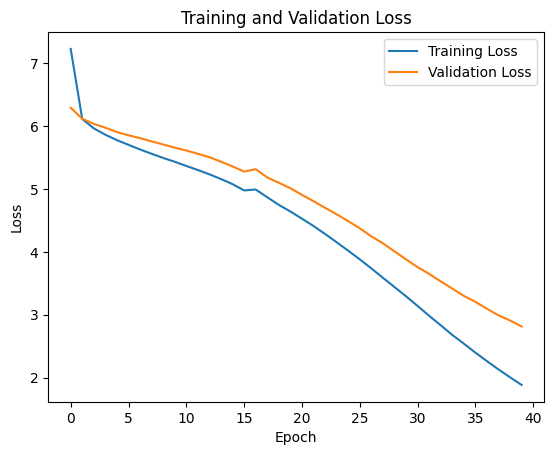

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'],     label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# 1. Encoder inference model
encoder_model = Model(
    inputs=qc_inputs,
    outputs=encoder_states
)

# 2. Decoder inference model
# Create new input placeholders for decoder’s previous states
decoder_state_input_h = Input(shape=(256,), name="input_h")
decoder_state_input_c = Input(shape=(256,), name="input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Re‑use the embedding layer and LSTM cell from training
dec_emb2 = embedding_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    inputs=[decoder_inputs] + decoder_states_inputs,
    outputs=[decoder_outputs2] + decoder_states2
)


In [24]:
import numpy as np

def decode_sequence(qc_seq):
    # qc_seq should be shape (1, max_qc_len)
    states_value = encoder_model.predict(qc_seq)
    target_seq   = np.array([[tokenizer.word_index['start']]])
    decoded_tokens = []
    for _ in range(max_a_len):
        out_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_idx      = np.argmax(out_tokens[0, -1, :])
        word             = tokenizer.index_word.get(sampled_idx, '<unk>')
        if word in ('end','<unk>'): break
        decoded_tokens.append(word)
        target_seq      = np.array([[sampled_idx]])
        states_value    = [h, c]
    return ' '.join(decoded_tokens)

In [ ]:
import numpy as np
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu

# 1. Helper for token‑level F1
def compute_f1(pred, true):
    p_tokens = pred.split()
    t_tokens = true.split()
    common = Counter(p_tokens) & Counter(t_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = num_same / len(p_tokens)
    recall    = num_same / len(t_tokens)
    return 2 * precision * recall / (precision + recall)

# 2. Decode all validation examples
preds = []
trues = val_df['answer'].tolist()
for qc_seq, true_ans in zip(val_qc, trues):
    # qc_seq has length max_qc_len, so reshape accordingly
    pred = decode_sequence(qc_seq.reshape(1, max_qc_len))
    preds.append(pred)


# 3. Compute metrics
exact_matches = np.mean([p == t for p, t in zip(preds, trues)])
f1_scores     = np.array([compute_f1(p, t) for p, t in zip(preds, trues)])
bleu_scores   = np.array([
    sentence_bleu([t.split()], p.split(),
                  smoothing_function=None)
    for p, t in zip(preds, trues)
])

print(f"Exact Match:  {exact_matches:.3f}")
print(f"Avg. F1 Score: {f1_scores.mean():.3f}")
print(f"Avg. BLEU:     {bleu_scores.mean():.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━